<a href="https://colab.research.google.com/github/AALivanova/BI_Stat_2021/blob/ML_hw1/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ЗАДАНИЕ 1

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import sklearn


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
plt.rcParams["figure.figsize"] = 12, 9 #задаем размеры изображений и параметры seed
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False) #качаем датасет

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000) #cсоздаем подвыборку из датасета, чтобы полегче жилось
X = X[idx_to_stay]
y = y[idx_to_stay]

(-0.5, 27.5, 27.5, -0.5)

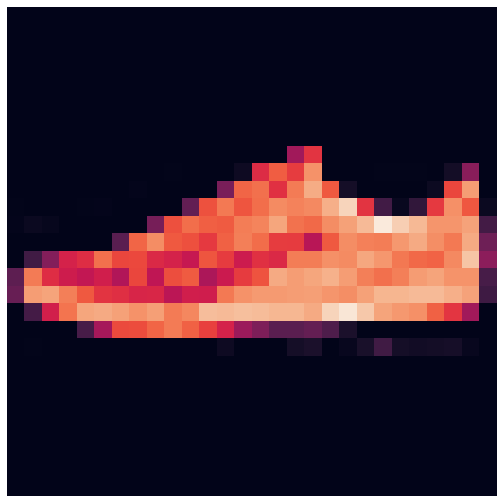

In [5]:
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28) #смотрим на случайную картинку
plt.imshow(image)
plt.axis("off")

1.1. Посмотрим на все классы

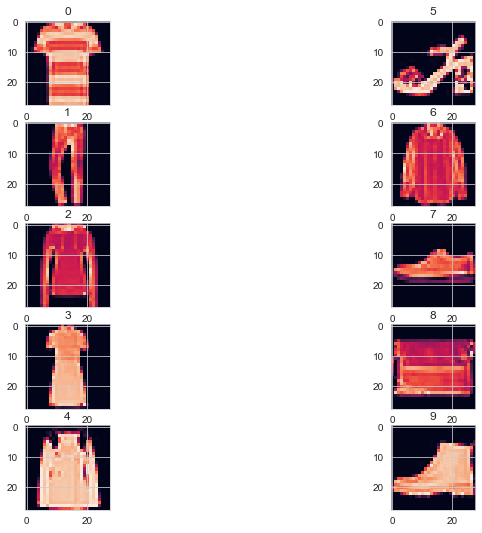

In [6]:
fig, axes = plt.subplots(5,2) #создаем сабплот величиной 5 на 2

for klass in range(0, 5): #перебираем классы от 0 до 4 и выбираем из них случайную картинку, запихиваем ее в сабплот
    subsetX = X[y==str(klass)]
    image = subsetX[np.random.choice(np.arange(subsetX.shape[0]))].reshape(28, 28)
    axes[klass, 0].imshow(image)
    axes[klass, 0].set_title(str(klass))

i = 0
for klass in range(5, 10): #перебираем классы от 5 до 9 и выбираем из них по случайной картинке, заполняем вторую колонку сабплота
    subsetX = X[y==str(klass)]
    image = subsetX[np.random.choice(np.arange(subsetX.shape[0]))].reshape(28, 28)
    axes[i, 1].imshow(image)
    axes[i, 1].set_title(str(klass))
    i += 1


<font size=3 color='purple'><b>
    <ul>
        <li>Обрати внимание на отступы: стандарт в Python - 4 пробела (1 tab), а не 2<br><br></li>
        <li> Для читабельности лучше не использовать длинные выражения (например, как тут в 5 строке), а разбивать на несколько: отдельно считаем индекс, отдельно фильтруем, отдельно решейпим <br><br></li>
        <li> Необходимости в двух циклах нет, можно сделать, например, так: </li>
    </ul></b></font>
    
```python
fig, axes = plt.subplots(5, 2, figsize=(12, 9))
axes = axes.reshape(-1)  # Изначально axes.shape = (5, 2), мы можем "распрямить" 
classes = sorted(list(set(y)))

for i, c in enumerate(classes):
    X_c = X[y==c]
    n_images = X_c.shape[0]
    rand_ind = np.random.randint(0, n_images)
    image = X_c[rand_ind].reshape(28, 28)
    axes[i].imshow(image)
    axes[i].set_title(c)
    axes[i].axis('off')
```

1.2. Сделаем небольшой EDA

In [7]:
classes = pd.Series(y) #создадим серию pandas из набор классов
column = ['classes']
ypandas= pd.DataFrame(data = classes, columns = column) #создадим датасет pandas из набора классов

ypandas.describe() #быстро охарактеризуем датасет найдем общее число картинок, проверим число уникальных классов, найдем самый большой класс и число картинок в нем
ypandas.groupby('classes').aggregate({'classes':'count'}).rename(columns={'classes':'number_of_images'}).reset_index()  #посчитаем число кратинок в каждом классе

,classes,number_of_images
0,0,93
1,1,102
2,2,95
3,3,121
4,4,96
5,5,98
6,6,101
7,7,79
8,8,109
9,9,106


<font size=3 color='purple'><b>
    <ul>
        <li>Не хватает итогового вывода</li>
    </ul></b></font>


### Самый большой класс 3 (платья) - 121 изображение

1.3. Разделите данные на train и test 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

1.4. KNN для бинарной классификации

In [9]:
X_bin_train = X_train[(y_train==str(0)) | (y_train==str(1))] #создаем сабсет X и y для бинарной классификаици, где будут только картинки классов 0 и 1
y_bin_train = y_train[(y_train==str(0)) | (y_train==str(1))]
X_bin_train.shape #их 146 в трейн выборке
X_bin_test = X_test[(y_test==str(0)) | (y_test==str(1))] #создаем сабсет X и y для бинарной классификаици, где будут только картинки классов 0 и 1
y_bin_test = y_test[(y_test==str(0)) | (y_test==str(1))]
X_bin_test.shape #их 49 в тecт выборке

(49, 784)

<font size=3 color='purple'><b>
    <ul>
        <li>Рекомендую в таком случае использовать np.isin:</li>
    </ul></b></font>
    
```python
train_mask = np.isin(y_train, ['0', '1'])
test_mask = np.isin(y_test, ['0', '1'])

X_bin_train = X_train[train_mask]
X_bin_test = X_test[test_mask]

```

In [10]:
import numpy as np
import statistics
from statistics import mode, StatisticsError


class KNNClassifier:
    """
    K-neariest-neighbor classifier using L1 loss
    """
    
    def __init__(self, k=1):
        self.k = k
    

    def fit(self, X, y):
        self.train_X = X
        self.train_y = y


    def predict(self, X, n_loops=0):
        """
        Uses the KNN model to predict clases for the data samples provided
        
        Arguments:
        X, np array (num_samples, num_features) - samples to run
           through the model
        num_loops, int - which implementation to use
        Returns:
        predictions, np array of ints (num_samples) - predicted class
           for each sample
        """
        
        if n_loops == 0:
            distances = self.compute_distances_no_loops(X)
        elif n_loops == 1:
            distances = self.compute_distances_one_loops(X)
        else:
            distances = self.compute_distances_two_loops(X)
        
        if len(np.unique(self.train_y)) == 2:
            return self.predict_labels_binary(distances)
        else:
            return self.predict_labels_multiclass(distances)


    def compute_distances_two_loops(self, X):
        """
        Computes L1 distance from every sample of X to every training sample
        Uses simplest implementation with 2 Python loops
        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        """
        num_test_samples = len(X)
        num_train_samples = len(self.train_X)
        distances = np.zeros(shape=(num_test_samples, num_train_samples))
        for j in range(num_train_samples):
            for i in range(num_test_samples):
                sample_dist = np.sum(np.abs(X[i, ] - self.train_X[j, ]))
                distances[i, j] = sample_dist
        return distances


    def compute_distances_one_loop(self, X):
        """
        Computes L1 distance from every sample of X to every training sample
        Vectorizes some of the calculations, so only 1 loop is used
        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        """
        num_test_samples = len(X)
        num_train_samples = len(self.train_X)
        distances = np.zeros(shape=(num_test_samples, num_train_samples))
        for i in range(num_test_samples):
            d = np.sum(np.abs(X[i, ] - self.train_X), axis=-1)
            distances[i, ] = d
        return distances
       


    def compute_distances_no_loops(self, X):
        """
        Computes L1 distance from every sample of X to every training sample
        Fully vectorizes the calculations using numpy
        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        """

        distances = np.sum(np.abs(X[:, np.newaxis] - self.train_X), axis=-1)
        return distances


    def predict_labels_binary(self, distances):
        """
        Returns model predictions for binary classification case
        
        Arguments:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        Returns:
        pred, np array of bool (num_test_samples) - binary predictions 
           for every test sample
        """

        k = self.k
        n_train = distances.shape[1]
        n_test = distances.shape[0]
        prediction = np.zeros(n_test)
        for i in range(n_test):
            dist_sorted = np.sort(distances[i, :])
            sample_dists = distances[i, :]
            k_dists = dist_sorted[:k, ]
            classi = []
            for min_dist in range(len(k_dists)):
                ind = list(sample_dists).index(k_dists[min_dist])
                klass_min = self.train_y[ind]
                classi.append(klass_min)
            try:
                sample_class_pred = statistics.mode(classi)
            except StatisticsError:
                sample_class_pred = klass_min

            prediction[i, ] = sample_class_pred
        return prediction

        
    def predict_labels_multiclass(self, distances):
        """
        Returns model predictions for multi-class classification case
        
        Arguments:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        Returns:
        pred, np array of int (num_test_samples) - predicted class index 
           for every test sample
        """

        n_train = distances.shape[1]
        n_test = distances.shape[0]
        prediction = np.zeros(n_test, np.int)
        k = self.k

        for i in range(n_test):
            dist_sorted = np.sort(distances[i, :])
            sample_dists = distances[i, :]
            k_dists = dist_sorted[:k, ]
            classi = []
            for min_dist in range(len(k_dists)):
                ind = list(sample_dists).index(k_dists[min_dist])
                klass_min = self.train_y[ind]
                classi.append(klass_min)
            classi_np = np.array(classi)
            sample_class_pred = np.argmax(np.bincount(classi_np))
            prediction[i, ] = sample_class_pred
        return prediction


<font size=3 color='purple'><b>
    <ul>
        <li>Все же лучше поместить этот класс в отдельный модуль .py и импортировать оттуда. Из ноутбуков импортировать сложно (и не нужно). У тебя knn_py.ipynb, а надо просто knn.py.<br><br></li>
        <li>Снова, обрати внимание на отступы: по языковым стандартам нужно 4 пробела (1 табуляция), а не 2.<br><br></li>
        <li>Pass в конце методов уже не нужен, ты ведь уже написала для них конкретные реализации</li>
    </ul></b></font>

<font size=3 color='purple'><b>
    Вместо конструкций вида:
</b></font>
```python
for i in range(len(a)):
    x = a[i]
```
<font size=3 color='purple'><b>
    Лаконичнее писать:
</b></font>
```python
for x in a:
    
```

<font size=3 color='purple'><b>
    Сами значения расстояний нас не интересуют, поэтому вместо сортировки значений и дальнейшего поиска конкретных значений, достаточно сделать, например, argsort:
</b></font>

```python
inds = np.argsort(distances)[:, :k]
    
```

In [11]:
knn_classifier = KNNClassifier(k=1) #создаем и обучаем наш классифайер на трейн выборке
knn_classifier.fit(X_bin_train, y_bin_train)

In [12]:
dists2loops = knn_classifier.compute_distances_two_loops(X_bin_test) #создаем матрицу расстояний между каждым трейн и каждый тест sample с помощью двух циклов
assert np.isclose(dists2loops[0, 30], np.sum(np.abs(X_bin_test[0] - X_bin_train[30])))
dists2loops

array([[52701., 57896., 31497., ..., 62868., 37755., 19107.],
       [38297., 31506., 63565., ..., 24482., 58947., 74821.],
       [51808., 58229., 25448., ..., 62289., 33226., 15722.],
       ...,
       [37767., 35324., 57929., ..., 32882., 54263., 73091.],
       [58101., 59348., 45625., ..., 62238., 36445., 34641.],
       [35933., 33678., 60383., ..., 33680., 61435., 72195.]])

In [13]:
np.argsort(dists2loops, axis=-1)

array([[129,  77,  18, ...,  69,  46, 119],
       [113, 102,  38, ...,  67,   9, 135],
       [ 76,  34,  60, ...,  69,  46, 119],
       ...,
       [ 90,  33, 113, ...,  62,   9, 135],
       [ 25,  84, 132, ...,  46, 142, 119],
       [ 46, 113,   1, ..., 105,   9, 135]], dtype=int64)

In [14]:
dists1loop = knn_classifier.compute_distances_one_loop(X_bin_test) #создаем матрицу расстояний между каждым трейн и каждый тест sample с помощью одного цикла
dists1loop


array([[52701., 57896., 31497., ..., 62868., 37755., 19107.],
       [38297., 31506., 63565., ..., 24482., 58947., 74821.],
       [51808., 58229., 25448., ..., 62289., 33226., 15722.],
       ...,
       [37767., 35324., 57929., ..., 32882., 54263., 73091.],
       [58101., 59348., 45625., ..., 62238., 36445., 34641.],
       [35933., 33678., 60383., ..., 33680., 61435., 72195.]])

In [15]:
dists1loop == dists2loops #проверим ка что они равны

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

<font size=3 color='purple'><b>
    <ul>
        <li>Здесь и далее: такое частичное отображение не является полноценной проверкой условия. Мало ли что скрыто в многоточиях... Можно например так:</li>
    </ul></b></font>
    
```python
np.all(dists1loop == dists2loops)
```

In [16]:
dist0loops = knn_classifier.compute_distances_no_loops(X_bin_test) #создаем матрицу расстояний между каждым трейн и каждый тест sample с помощью полной векторизации

In [17]:
dist0loops == dists2loops #проверим ка тоже что они равны

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [18]:
%timeit knn_classifier.compute_distances_two_loops(X_bin_test) #сделаем тест по времени для каждого варианта создания матриц расстовний
%timeit knn_classifier.compute_distances_one_loop(X_bin_test)
%timeit knn_classifier.compute_distances_no_loops(X_bin_test)

130 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
24 ms ± 994 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
62 ms ± 793 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
prediction = knn_classifier.predict(X_bin_test) #найдем список предсказанных классов для тестовой выборки
prediction 


array([1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.])

In [20]:
y_bin_test

array(['1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '1', '1',
       '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1',
       '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1',
       '0', '0', '0', '1', '1', '1', '1', '0', '0', '0'], dtype=object)

In [82]:
import numpy as np


def binary_classification_metrics(y_pred, y_true):
    """
    Computes metrics for binary classification
    Arguments:
    y_pred, np array (num_samples) - model predictions
    y_true, np array (num_samples) - true labels
    Returns:
    precision, recall, f1, accuracy - classification metrics
    """
    #расчет количества  ошибок разных типов
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    for i in range(len(y_pred)):
        if (y_pred[i, ] == 1) and (y_true[i, ] == 1):
            TP +=1
        if (y_pred[i, ] == 0) and (y_true[i, ] == 0):
            TN +=1
        if (y_pred[i, ] == 0) and (y_true[i, ] == 1):
            FN += 1
        if (y_pred[i, ] == 1) and (y_true[i, ] == 0) :
            FP += 1
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    recall = TP/(TP + FN)
    precision = TP/(TP + FP)
    F1 = (precision * recall) * 2/ (precision + recall)
    d = dict(); 
    d['accuracy'] = accuracy
    d['recall'] = recall
    d['precision'] = precision
    d['F1'] = F1
    return d


def multiclass_accuracy(y_pred, y_true):
    """
    Computes metrics for multiclass classification
    Arguments:
    y_pred, np array of int (num_samples) - model predictions
    y_true, np array of int (num_samples) - true labels
    Returns:
    accuracy - ratio of accurate predictions to total samples
    """
    positive = 0
    negative = 0

    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    for i in range(len(y_pred)):
        if y_pred[i, ] == y_true[i, ]:
            positive +=1
        else:
            negative += 1

    accuracy = positive/(positive + negative)

    return accuracy



def r2(y_pred, y_true):
    """
    Computes r-squared for regression
    Arguments:
    y_pred, np array of int (num_samples) - model predictions
    y_true, np array of int (num_samples) - true values
    Returns:
    r2 - r-squared value
    """

    sum_chislitel = 0
    for i in range(len(y_pred)):
        dist = (y_true[i] - y_pred[i]) ** 2
        sum_chislitel += dist

    sum_znamenatel = 0
    for i in range(len(y_pred)):
        dist = (y_true[i] - y_true.mean()) ** 2
        sum_znamenatel += dist
    r2 = 1 - (sum_chislitel/ sum_znamenatel)
    return r2





def mse(y_pred, y_true):
    """
    Computes mean squared error
    Arguments:
    y_pred, np array of int (num_samples) - model predictions
    y_true, np array of int (num_samples) - true values
    Returns:
    mse - mean squared error
    """
    summa = 0
    for i in range(len(y_pred)):
        dist = (y_true[i] - y_pred[i]) ** 2
        summa += dist
    if len(y_pred) != 0:
        mse = (1/len(y_pred)) * (summa)
    else:
        print("No y predicted!")
    
    return mse



def mae(y_pred, y_true):
    """
    Computes mean absolut error
    Arguments:
    y_pred, np array of int (num_samples) - model predictions
    y_true, np array of int (num_samples) - true values
    Returns:
    mae - mean absolut error
    """
    summa = 0
    for i in range(len(y_pred)):
        dist = abs(y_true[i] - y_pred[i])
        summa += dist
    if len(y_pred) != 0:
        mae = (1/len(y_pred)) * summa
    else:
        print("No y predicted!")
    return mae



<font size=3 color='purple'><b>
    <ul>
        <li>Если будет деление на 0, программа упадёт. Следует отдельно предусмотреть такие случаи. <font size=3 color='red'> -0.5 баллов</font></li><br>
        <li>Явно не хватает векторизации арифметических операций</li>
    </ul></b></font>

### я добавила проверку на деление на ноль

In [22]:
binary_classification_metrics(prediction, y_bin_test) #рассчитываем основные метрики качества модели

{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0, 'F1': 1.0}

In [23]:
y_bin_test = y_bin_test.astype(int)

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score #проверим, что правильно считаем метрики
precision_score(y_bin_test, prediction)

1.0

In [25]:
recall_score(y_bin_test, prediction)

1.0

In [26]:
f1_score(y_bin_test, prediction)

1.0

In [27]:
accuracy_score(y_bin_test, prediction)

1.0

In [28]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []
    y_test = y_test.astype(int)
    y_train = y_train.astype(int)
    for param in params:
        knn_classifier = KNNClassifier(k=param) #создаем и обучаем наш классифайер на трейн выборке
        knn_classifier.fit(X_train, y_train)
        y_pred_train = knn_classifier.predict(X_train) #предсказание на трейн
        y_pred_test = knn_classifier.predict(X_test) #предсказание на тестовой
        accuracy_train = binary_classification_metrics(y_pred_train, y_train)['accuracy'] #точность предсказания на трейн выборке
        accuracy_test = binary_classification_metrics(y_pred_test, y_test)['accuracy'] #точность предсказания на test выборке
        train_metrics.append(accuracy_train)
        test_metrics.append(accuracy_test)
    return train_metrics, test_metrics


In [29]:
params = range(1, 30) #пробуем оценить accuracy нашей модельи с набором разных к. Пожалуй, лучше брать accuracy, так как нам важны все точные ответы и TN и TP
train_metrics, test_metrics = find_best_k(X_bin_train, y_bin_train, X_bin_test, y_bin_test, params, metric='accuracy')
train_metrics

[1.0,
 0.9931506849315068,
 1.0,
 0.9794520547945206,
 0.9931506849315068,
 0.9657534246575342,
 0.9726027397260274,
 0.9794520547945206,
 0.9794520547945206,
 0.9794520547945206,
 0.9863013698630136,
 0.9726027397260274,
 0.9794520547945206,
 0.9657534246575342,
 0.9726027397260274,
 0.9657534246575342,
 0.9657534246575342,
 0.958904109589041,
 0.958904109589041,
 0.952054794520548,
 0.952054794520548,
 0.9657534246575342,
 0.958904109589041,
 0.952054794520548,
 0.952054794520548,
 0.9452054794520548,
 0.9452054794520548,
 0.9246575342465754,
 0.9383561643835616]

In [30]:
test_metrics

[1.0,
 0.9795918367346939,
 1.0,
 0.9591836734693877,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9795918367346939,
 0.9795918367346939,
 0.9795918367346939,
 0.9795918367346939,
 0.9795918367346939,
 0.9795918367346939,
 0.9795918367346939,
 0.9795918367346939,
 0.9795918367346939,
 0.9795918367346939]

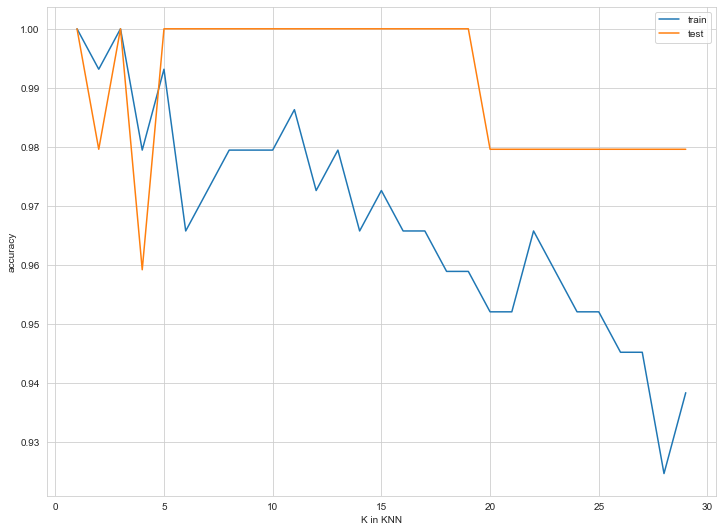

In [31]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("accuracy"); #кажется, что наиболее оптимально использовать k от 5 до 20, в идеале 5

1.5. Многоклассоввая классификация 

In [32]:
y_train = y_train.astype(int)
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train) #обучим модель на полной трейн выборке (где есть все классы, а не только 0 и 1)
prediction = knn_classifier.predict(X_test) #предскажем классы
prediction

C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


array([1, 5, 7, 2, 0, 3, 1, 7, 6, 7, 0, 6, 9, 4, 0, 6, 8, 4, 9, 7, 9, 8,
       1, 9, 9, 9, 4, 4, 0, 5, 0, 7, 3, 3, 2, 3, 6, 9, 3, 2, 0, 0, 8, 3,
       2, 8, 4, 3, 1, 6, 9, 9, 2, 4, 5, 4, 1, 7, 4, 8, 5, 4, 1, 2, 7, 1,
       9, 3, 7, 7, 6, 9, 6, 9, 7, 8, 0, 7, 2, 1, 5, 3, 8, 8, 9, 6, 3, 3,
       6, 0, 3, 4, 5, 7, 6, 3, 7, 4, 6, 5, 2, 4, 5, 5, 1, 0, 8, 8, 1, 5,
       6, 8, 6, 1, 1, 1, 2, 1, 2, 9, 3, 9, 6, 5, 0, 8, 0, 5, 6, 0, 2, 2,
       8, 2, 3, 9, 9, 2, 4, 8, 2, 1, 0, 3, 6, 8, 3, 1, 2, 5, 4, 3, 9, 3,
       7, 0, 1, 8, 0, 3, 0, 8, 1, 7, 7, 8, 8, 9, 4, 1, 7, 3, 6, 9, 6, 6,
       2, 8, 6, 2, 9, 0, 5, 3, 8, 3, 2, 6, 2, 9, 0, 3, 1, 0, 7, 3, 5, 9,
       9, 3, 7, 2, 7, 8, 5, 4, 5, 1, 8, 4, 1, 0, 8, 1, 0, 8, 0, 0, 6, 6,
       8, 2, 5, 1, 4, 8, 7, 1, 0, 6, 2, 3, 9, 2, 7, 5, 2, 1, 1, 0, 3, 8,
       9, 7, 3, 3, 2, 0, 9, 9])

In [33]:
multiclass_accuracy(prediction, y_test) 

0.764

<font size=3 color='purple'><b>
    <ul>
        <li>Продублирую: в задании было требование вынести реализацию в отдельный модуль metrics.py. Вижу, что у тебя возникли с этим трудности, попробуй почитать [тут](https://chrisyeh96.github.io/2017/08/08/definitive-guide-python-imports.html), как это устроено. В следующий раз это будет считаться ошибкой.</li>
    </ul></b></font>

C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


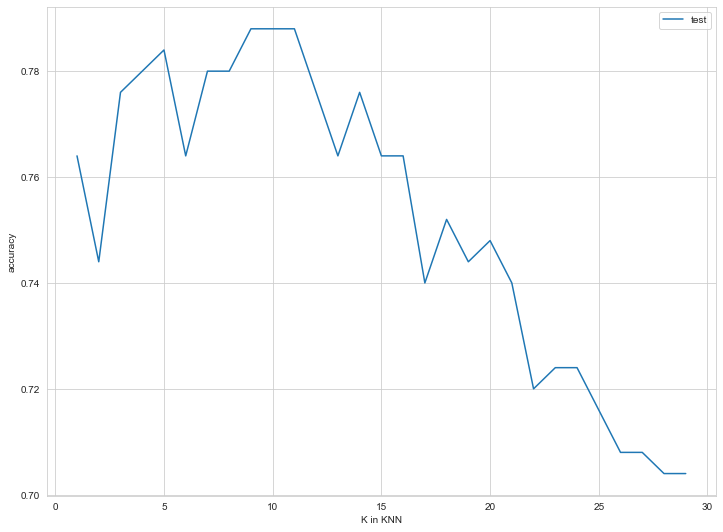

In [34]:
test_metrics = [] #Найдем оптимальное к для мультиклассовой классификации
for i in range(1, 30):
    knn_classifier = KNNClassifier(k=i)
    knn_classifier.fit(X_train, y_train) #обучим модель на полной трейн выборке (где есть все классы, а не только 0 и 1)
    prediction = knn_classifier.predict(X_test)
    accuracy = multiclass_accuracy(prediction, y_test) 
    test_metrics.append(accuracy)
plt.plot(range(1, 30), test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("accuracy"); #кажется, что наиболее оптимально использовать k=10

In [35]:
y_train = y_train.astype(int)
knn_classifier = KNNClassifier(k=10)
knn_classifier.fit(X_train, y_train) #обучим модель с оптимальным k
prediction = knn_classifier.predict(X_test) #предскажем классы
multiclass_accuracy(prediction, y_test) #рассчитаем accuracy

C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.788

ЗАДАНИЕ 2

In [36]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [37]:
X, y = load_diabetes(as_frame=True, return_X_y=True)
X['target'] = y #добавим таргетную переменную в датасет и осмотрим его
diabetes = X
diabetes


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


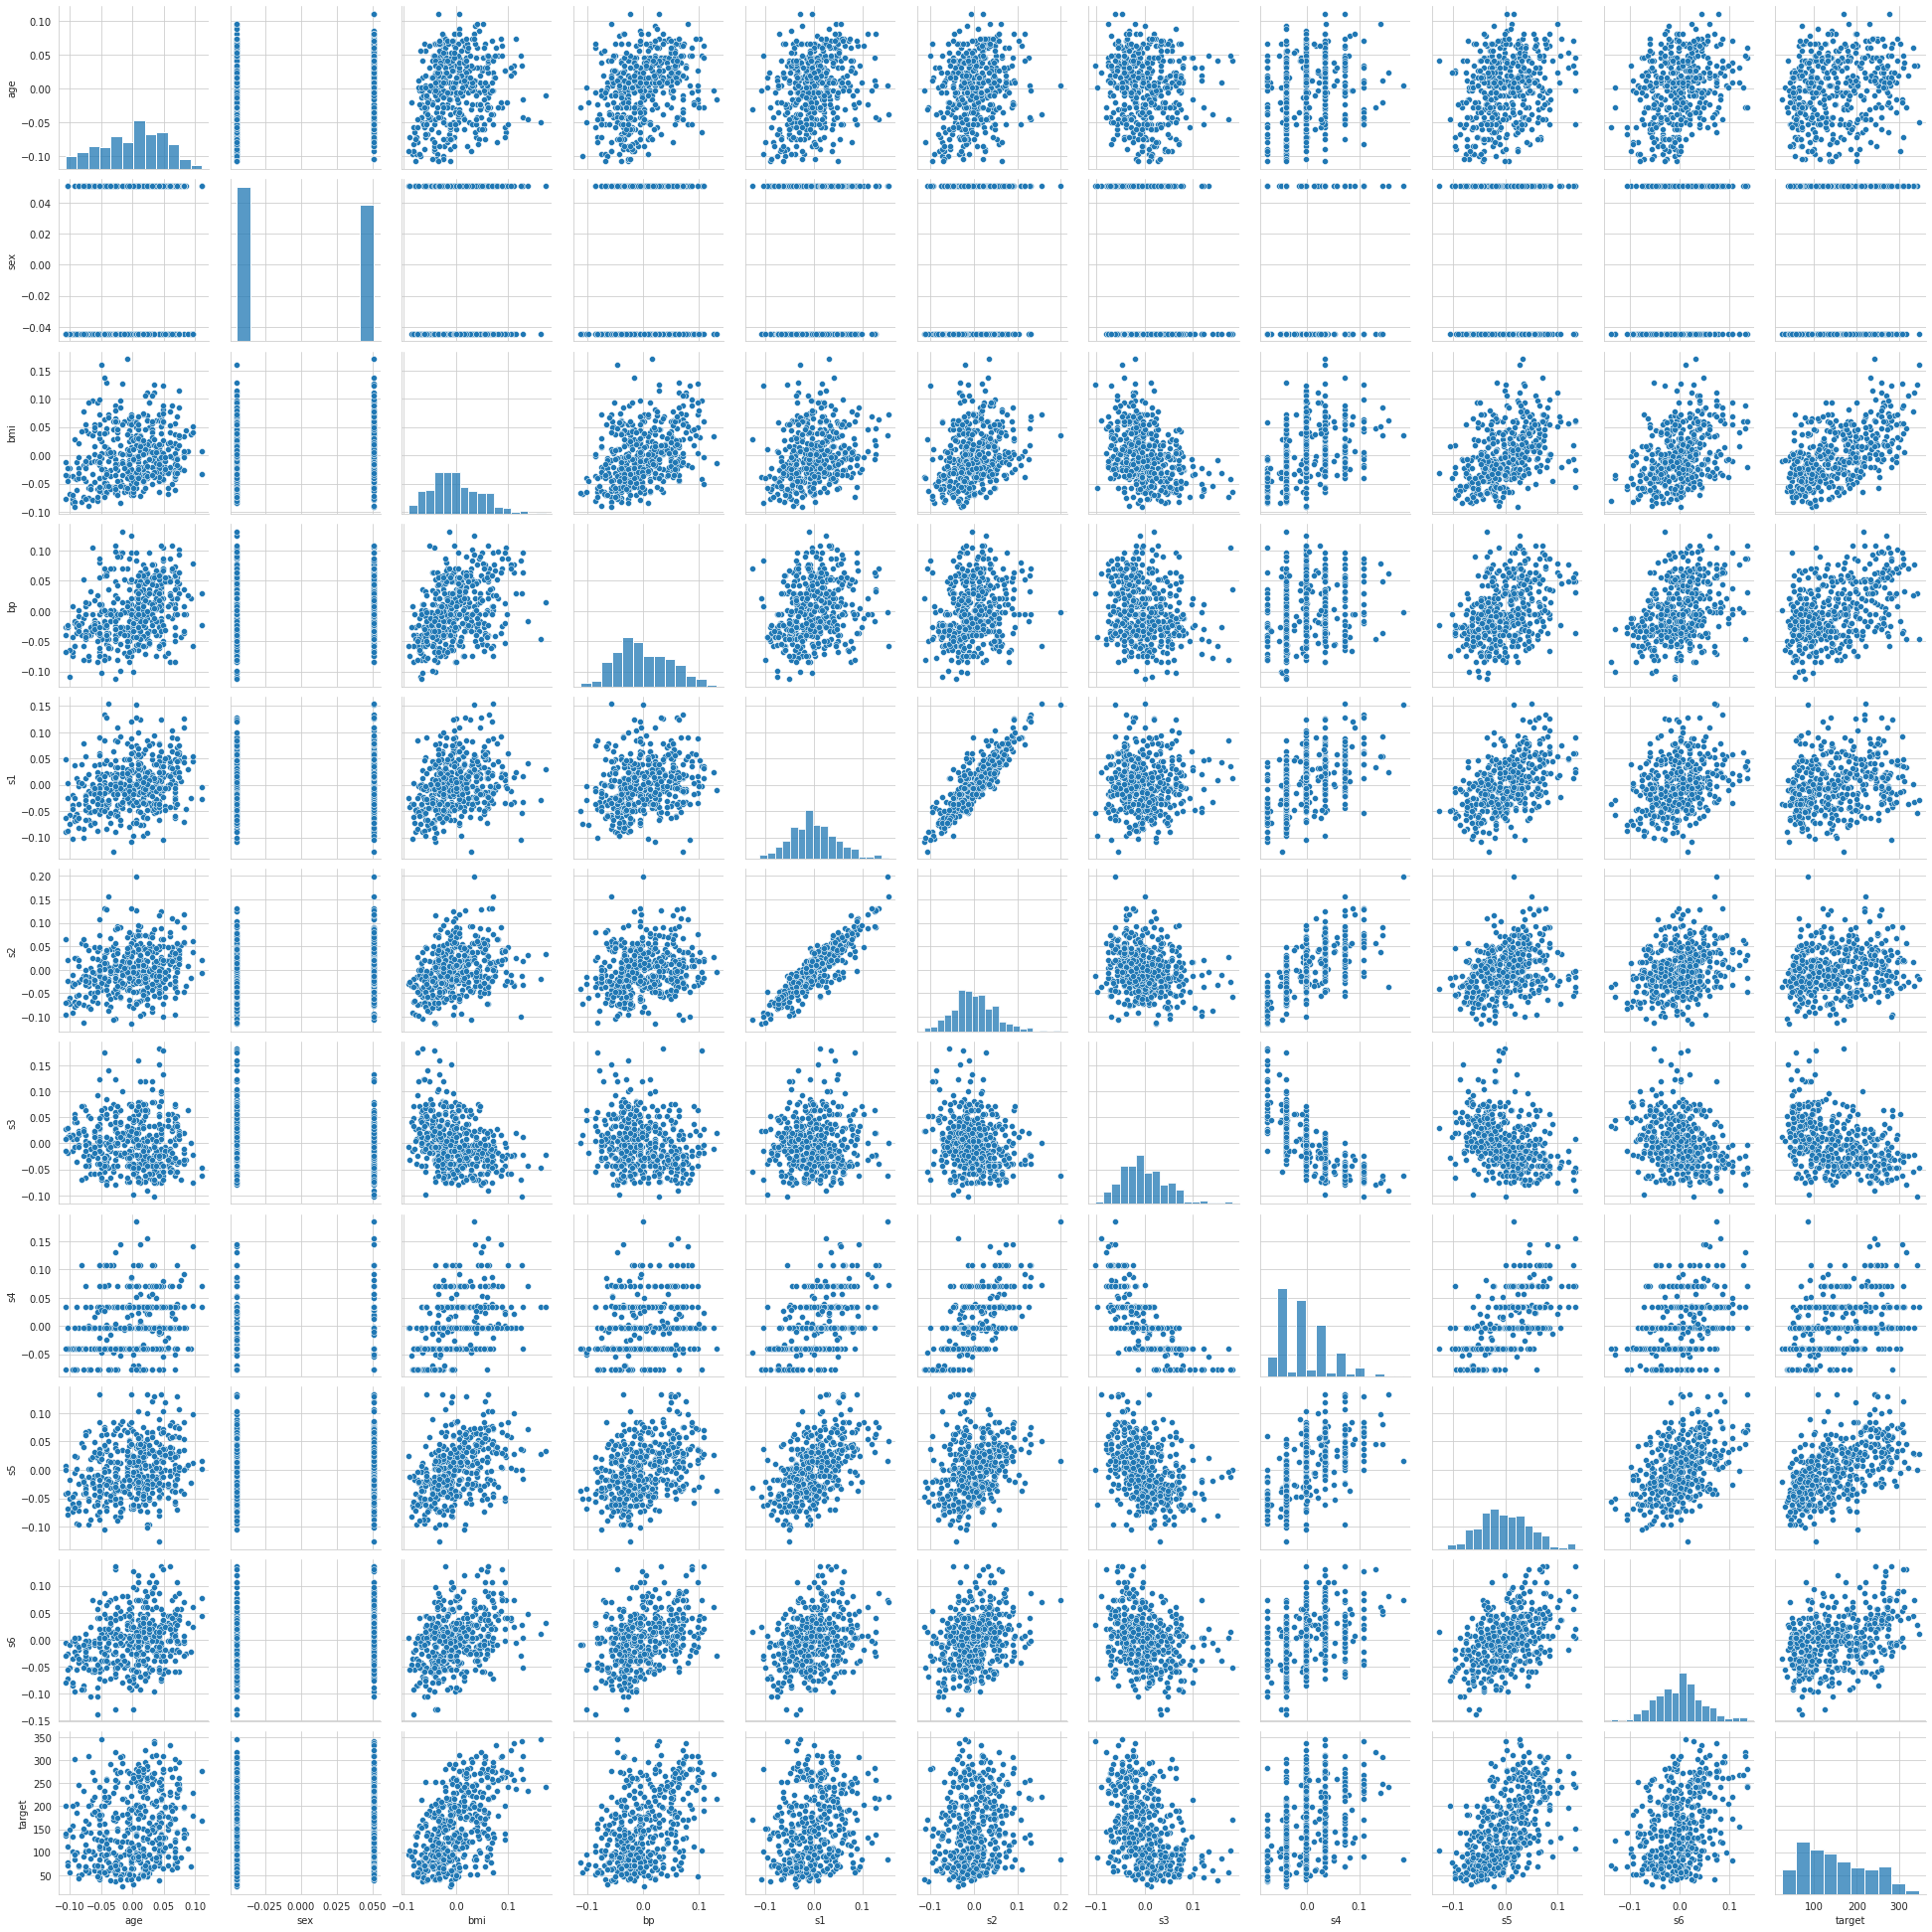

In [83]:
sns.pairplot(diabetes) #поглядим на датасет. переменная sex явно номинативная, остальные количественные. Очень хорошо коррелируют s1 и s2

<AxesSubplot:>

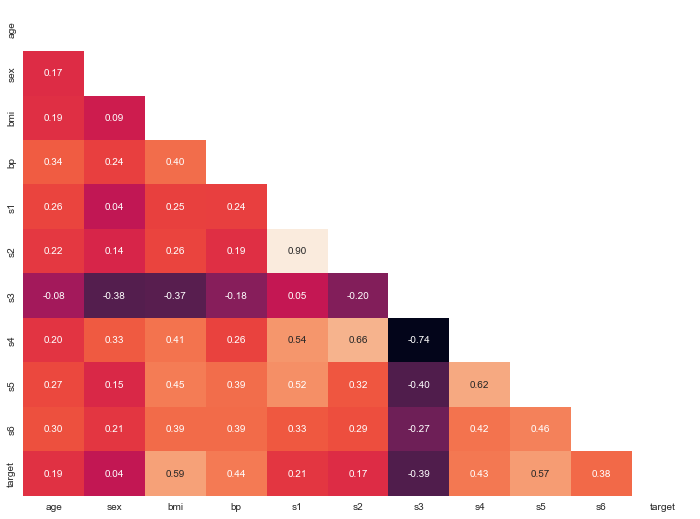

In [38]:
sns.heatmap(diabetes.corr(method='pearson'),annot=True,fmt='.2f',mask=np.triu(diabetes.corr(method='pearson')),cbar=False)

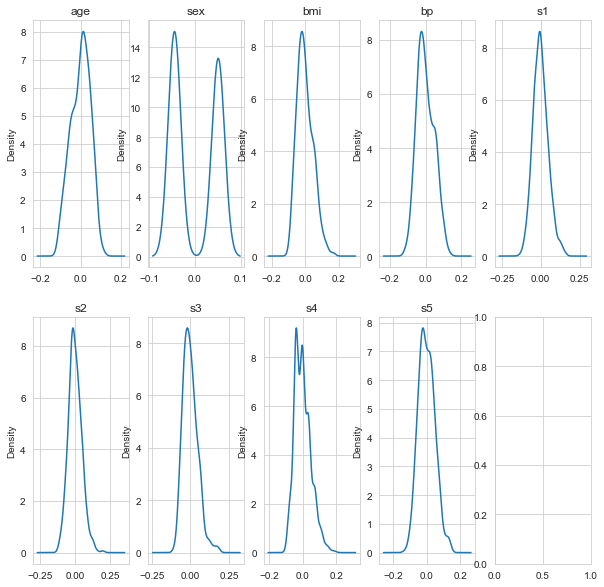

In [39]:
features = list(diabetes.iloc[:, 0:9]) #посмотрим на распределения предикторов, похоже, что все средние преведены к 0 и масштабированы по стандартному отклонению

fig,ax = plt.subplots(2,5,figsize=(10,10))
row = col = 0
for n,i in enumerate(features):
    if (n%5 == 0) & (n > 0):
        row += 1
        col = 0
    diabetes[i].plot(kind="kde",ax=ax[row,col])
    ax[row,col].set_title(i)
    col += 1

In [42]:
features

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5']

In [40]:
diabetes.describe().T #убедимся в этом, и действительно std везде один и тот же. получается, стандартизацию можно не проводить? 

,count,mean,std,min,25%,50%,75%,max
age,442.0,-3.639623e-16,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.309912e-16,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-8.013951e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,1.289818e-16,0.047619,-0.112400,-0.036656,-0.005671,0.035644,0.132044
s1,442.0,-9.042540e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,1.301121e-16,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-4.563971e-16,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,3.863174e-16,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,-3.848103e-16,0.047619,-0.126097,-0.033249,-0.001948,0.032433,0.133599
s6,442.0,-3.398488e-16,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


In [44]:
from scipy.stats import normaltest #можно проверить данные на нормальность. 
for i in features:
    print({normaltest(diabetes[i].values)})

{NormaltestResult(statistic=22.980727382695587, pvalue=1.0228182153992174e-05)}
{NormaltestResult(statistic=1895.7402597458938, pvalue=0.0)}
{NormaltestResult(statistic=23.665619193944988, pvalue=7.262331793832793e-06)}
{NormaltestResult(statistic=15.62072005916215, pvalue=0.000405512025210947)}
{NormaltestResult(statistic=11.2085275549357, pvalue=0.003682130413975457)}
{NormaltestResult(statistic=18.03128290368439, pvalue=0.00012149451358986439)}
{NormaltestResult(statistic=47.88065264242953, pvalue=4.007267957312441e-11)}
{NormaltestResult(statistic=36.31436098718564, pvalue=1.3014776207789513e-08)}
{NormaltestResult(statistic=6.463554493369442, pvalue=0.0394872577910996)}


<font size=3 color='purple'><b>
    <ul>
        <li>Вижу чиселки. А какой из них можно сделать вывод?</li>
    </ul></b></font>

### Если p>0.05, то распределение не отличается от нормального. Т.о. переменные age, bmi, s3 и s4 нормально распределены, остальные -нет


2.2. Регрессионная модель (1 балл)

In [83]:
X, y = load_diabetes(as_frame=True, return_X_y=True) #вернем обратно датасеты с x и y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED) #сплитим на трейн и тест

reg_model = KNeighborsRegressor(n_neighbors=5) #создаем модель регрессии на основе алгоритма к ближайших соседей
reg_model.fit(X_train, y_train) #обучаем на трейн 
prediction = reg_model.predict(X_test) #делаем предсказания для теста

2.3. Метрики регресии

In [84]:
y_test = np.array(y_test) #посмотрим на праивльные ответы
y_test

array([259., 128., 116., 196., 220., 292., 182., 179.,  59.,  71., 172.,
       248., 128., 163., 171., 166., 233.,  68., 202.,  90.,  90.,  95.,
        78., 208.,  96., 214.,  77.,  97., 232., 302., 221., 146., 163.,
        91., 101., 202., 118., 172., 127., 126., 184., 220.,  89., 219.,
       161.,  64., 191.,  49., 311., 118., 281., 217., 180.,  72., 270.,
        70., 102., 139.,  83.,  74., 111.,  50., 248., 153., 341., 107.,
       116., 182., 151., 222., 178., 173.,  94., 212., 141., 144.,  72.,
       137., 177., 147.,  86., 131., 263.,  91., 168.,  84., 244.,  37.,
       214., 132., 122.,  63., 281.,  91., 308.,  97.,  39., 138.,  97.,
       214.,  90., 150.,  87.,  53., 121.,  49., 197., 102.,  65., 283.,
       187.])

In [85]:
prediction #посмотрим на предсказания нрашей модели

array([226.2, 119.2, 170. , 135.8, 146.6, 165.6, 125.4, 114.4,  88.8,
        67.2, 133.6, 228. , 225.4, 221.4, 178.4, 169. , 218.2, 136.2,
       218.6,  75.4,  99.4, 150.6, 137. , 199.8,  73.8, 110.4,  59.2,
       115.4, 215. , 117.2, 139. , 173.8, 144.8, 169.8, 103.2, 105.8,
        76.4, 145.6, 175. , 123.6, 187.8, 250.2, 164.2, 123.6, 150. ,
        97.2, 181.4,  73.6, 185. , 195.2, 158.4, 220. , 268. , 106.6,
       220.2,  68.4, 104. , 195.8,  83.2,  79. ,  84. , 107.6, 187.4,
       117.4, 272.4, 144. ,  58. , 118.8, 234.6, 205.4, 186.2, 187. ,
        97.2, 173. , 152.4, 162.4,  88.4, 124.4, 121.4, 113.2,  97.2,
        84.2, 268.2, 103.6, 161.6, 103.4, 191.8, 105.8, 105.2, 257. ,
       185. ,  87.4, 219.8, 161. , 277.4,  77.8,  74. ,  62.4, 118.4,
       159. , 163.8, 189. ,  90.2,  96.4, 219.8, 121.8, 165.6,  94.8,
       153. , 148.2,  62.6])

In [86]:
r2(prediction, y_test) #рассчитаем r2

0.32860513411168624

In [76]:
mse(prediction, y_test) #рассчитаем mse

3364.9542342342334

In [77]:
mae(prediction, y_test) #рассчитаем mae

44.75315315315314

In [81]:
sklearn.metrics.r2_score(y_test, prediction) #проверим себя встроенными методами ддля расчета метрик в библиотеке sklearn

0.32860513411168624

In [79]:
sklearn.metrics.mean_absolute_error(prediction, y_test) 

44.75315315315314

In [57]:
sklearn.metrics.mean_squared_error(prediction, y_test) 

3364.9542342342347

In [80]:
print(sklearn.metrics.r2_score(y_test, prediction))
print(sklearn.metrics.mean_absolute_error(y_test, prediction))
print(sklearn.metrics.mean_squared_error(y_test, prediction))

0.32860513411168624
44.75315315315314
3364.9542342342347


<font size=3 color='purple'><b>
    <ul>
        <li>Снова чиселки. В задании спрашивается об интерпретации этих значений. 44.7 mae в контексте исходных данных - это много или мало? <font size=3 color='red'> -0.5 баллов</font></li>
    </ul></b></font>

### значение r2 маловато, mae=44 велико, это же сумма обсолютных ошибок, уичтывая, что у нас предсказываемые числа в районе 100-200, это значит что мы ошиблись для каждого предсказания примерно на треть-четверть

Text(0.5, 1.0, 'mae')

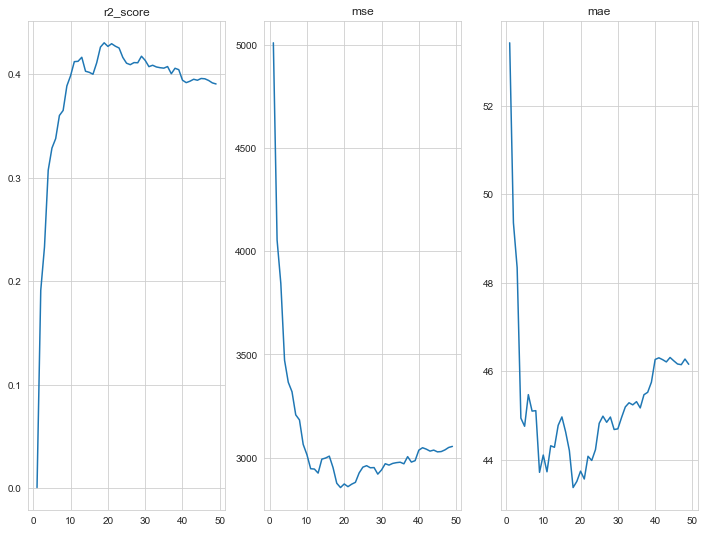

In [69]:
k_values = range(1, 50)
scores_data = pd.DataFrame()
y_test = np.array(y_test)
for k in k_values:
    reg_model = KNeighborsRegressor(n_neighbors=k)
    reg_model.fit(X_train, y_train)
    prediction = reg_model.predict(X_test)
    R2 = r2(y_test, prediction)
    MSE = mse(prediction, y_test)
    MAE = mae(prediction, y_test)
    temp_score_data = pd.DataFrame({'k': [k], 'r2_score': [R2], 'mse': [MSE], 'mae': [MAE]})
    scores_data = scores_data.append(temp_score_data)
  

plt.subplot(1, 3, 1)
plt.plot(scores_data['k'], scores_data['r2_score'])
plt.title("r2_score") #r2 с увеличением к только падает, поэтому по идее лучше сотавить k=1

plt.subplot(1, 3, 2)
plt.plot(scores_data['k'], scores_data['mse'])
plt.title("mse") # по идее, чем ближе к нулю, тем лучше. 

plt.subplot(1, 3, 3)
plt.plot(scores_data['k'], scores_data['mae'])
plt.title("mae") #по идее тоже, чем ближе к 0 тем лучше

<font size=3 color='purple'><b>
    <ul>
        <li>У тебя некорректно реализована функция r2. Чтобы она стала правильной, нужно поменять местами аргументы. R2 - несимметричная функция, [документация sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) фиксирует порядок аргументов: y_true, y_pred. Ты сравниваешь неправильное с неправильным, поэтому оно и совпадает :) <font size=3 color='red'> -1 балл</font></li><br>
        <li>Почему не используешь здесь свою же функцию _find_best_k_?</li>
    </ul></b></font>

### переделала запись для расчета r2

In [ ]:
scores_data[(scores_data['mae'] == scores_data['mae'].min())] #если по mae, то оптимальное k=18. на таком k и показатель r2 самый высокий тоже

,k,r2_score,mse,mae
0,18,-0.449514,2875.990824,43.367367


СОЦИАЛИЗАЦИЯ


https://drive.google.com/file/d/1M9r_jhKH5Py00IsAMvK2B9f3VnQZugK8/view?usp=sharing

<font size=3 color='purple'><b>
Итоговый балл <font size=3 color='green'> 18 - 2 + 0.5 = 16.5 баллов</font>